# DCGAN trained on CIFAR10 dataset

Implementing a DCGAN to generate images, trained on CIFAR10 dataset

In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Activation, BatchNormalization, Flatten, Input, Reshape
from keras.layers import UpSampling2D, Conv2D, MaxPool2D, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import sys

Using TensorFlow backend.
/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class DCGAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.noise_dim = 100
        
        opt = Adam(lr=0.0002, beta_1=0.3)
        
        #Discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=opt,
                                   metrics=['accuracy'])
        
        #Generator
        self.generator = self.build_generator()

        z = Input(shape=(self.noise_dim,))
        generated_img = self.generator(z)
        self.discriminator.trainable= False
        discriminator_result = self.discriminator(generated_img)
        
        #Combined model
        self.combined = Model(z, discriminator_result)
        print("Combined Model:")
        print(self.combined.summary())
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=opt)
        
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(2*2*128, 
                        input_dim=self.noise_dim, 
                        kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation(activation='relu'))
        model.add(Reshape((2,2,128), input_shape=(128*2*2,)))
        model.add(Dropout(0.3))
        model.add(Conv2DTranspose(128, 
                         kernel_size=(5,5),
                         strides=2,
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))
        model.add(Conv2DTranspose(64, 
                         kernel_size=(5,5),
                         strides=2,
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))
        model.add(Conv2DTranspose(32, 
                         kernel_size=(5,5),
                         strides=2,
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))
        model.add(Conv2DTranspose(3, 
                         kernel_size=(5, 5),
                         strides=2,
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(Activation('tanh'))
        print("Generator:")
        print(model.summary())
        return model
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(
                Conv2D(8, 
                kernel_size=(5, 5),
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform',
                input_shape=self.img_shape))
        model.add(BatchNormalization(momentum=0.5)) 
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(
                Conv2D(64, 
                kernel_size=(5, 5),
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(
                Conv2D(128, 
                kernel_size=(5, 5),
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        print("Discriminator:")
        print(model.summary())
        return model
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        #Load dataset
        (X_train, _), (_, _) = cifar10.load_data()
        
        #Rescale between -1 to 1
        X_train = X_train/127.5 - 1
        
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))
        
        self.d_losses = []
        self.g_losses = []
        
        for epoch in range(epochs):
            #Train discriminator
            
            #Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.uniform(0, 1, (batch_size, self.noise_dim))
            
            generated_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #Train generator
            
            noise = np.random.uniform(0, 1, (batch_size, self.noise_dim))
            
            g_loss = self.combined.train_on_batch(noise, valid)
            
            print("\r%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss), end="")
            sys.stdout.flush()
            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            if(epoch % sample_interval == 0):
                self.sample_images(epoch)
                
        return self.d_losses, self.g_losses
        
    def sample_images(self, epoch):
        print("")
        r, c = 5, 5
        noise = np.random.uniform(0,1,(r*c, self.noise_dim))
        generated_imgs = self.generator.predict(noise)
            
        #Rescale images between 0 to 1
        generated_imgs = 0.5*generated_imgs+0.5
            
        fig, axs = plt.subplots(r,c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt+=1
        fig.savefig("images/%d.png" % epoch)
        plt.close()
            
    def show_final(self):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r*c, self.noise_dim))
        generated_imgs = self.generator.predict(noise)
        
        #Rescale to 0 to 1
        generated_imgs = 0.5 * generated_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt +=1
        plt.show()
        fig.savefig("images/final.png")
        plt.close()

In [3]:
dcgan = DCGAN()

Discriminator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 8)         608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          12864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0     

In [4]:
d_losses, g_losses = dcgan.train(epochs=10000, batch_size=128, sample_interval=500)

/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.930631, acc: 46.09%] [G loss: 0.945552]
500 [D loss: 0.057629, acc: 98.83%] [G loss: 0.454618]]
1000 [D loss: 0.520374, acc: 70.31%] [G loss: 2.549693]
1500 [D loss: 0.714935, acc: 61.33%] [G loss: 1.431666]
2000 [D loss: 0.496157, acc: 75.00%] [G loss: 1.313056]
2500 [D loss: 0.776043, acc: 57.81%] [G loss: 1.126846]]
3000 [D loss: 0.225918, acc: 92.19%] [G loss: 0.127372]]
3500 [D loss: 0.183148, acc: 93.36%] [G loss: 0.203127]]
4000 [D loss: 0.095245, acc: 98.44%] [G loss: 0.115053]]
4500 [D loss: 1.063972, acc: 52.73%] [G loss: 0.676699]]
5000 [D loss: 0.521940, acc: 73.05%] [G loss: 0.349553]]
5500 [D loss: 0.107826, acc: 97.66%] [G loss: 0.177494]]
6000 [D loss: 0.028923, acc: 99.22%] [G loss: 0.038553]]
6500 [D loss: 0.048160, acc: 100.00%] [G loss: 0.095071]
7000 [D loss: 0.504067, acc: 73.83%] [G loss: 0.269051]]
7500 [D loss: 0.100210, acc: 98.44%] [G loss: 0.076828]]
8000 [D loss: 0.336994, acc: 85.94%] [G loss: 0.155704]]
8500 [D loss: 0.767449, acc: 51.17%] [G

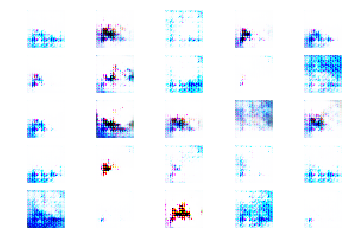

In [12]:
dcgan.show_final()

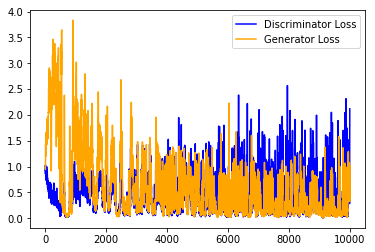

In [7]:
plt.plot(d_losses, color='blue')
plt.plot(g_losses, color='orange')
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.show()